# Forecasting Model

Here we will conduct a simple forecasting model to extrapolate our water equivalence measurements directly.

Our workflow is as follows:
- **Load data**: Pull our existing data from our finished data collection `UCRB_Ulmo_Current.csv`
- **Clean Dataframe**: We need the dataframe in long format and with only the `Station_ID` fields with our values in the attributes and time as our index.
- **Plot and make Stationary**: We will plot our time series to inspect it for **seasonality** and **trend**. After identifying trend and seasonality, we'll remove both so that we can model the noise. We'll put the seasonality and trend back into the results at the end.
- **Train and Test Model**: We'll be comparing between an **AR**, **MA**, and an **ARIMAS** model for the purpose of this project.
- **Run chosen model for all sites**: We will have to run a pipeline for the chosen model to run the modeling process for each SNOTEL weatherstation individually.
- **Add Predictions to a new CSV**: Export a CSV containing our predicted results. Since we've already done our EBKs for the existing data. We will need to create a new CSV for the predicted values to run through our ArcGIS Pro workflow.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# Since we don't want to be reliant on the intervals of the data pulled from the SNOTEL API previously,
# we'll conduct a fresh pull with daily data for this model.
import ulmo
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Start Date in YYYY-mm-dd format by relative year difference
startdate = datetime.now() - relativedelta(years=40)
startdate = startdate.strftime('%Y-%m-%d')

# Today's date
today = datetime.today().strftime('%Y-%m-%d')

In [4]:
# Pulling site data from our previously isolated sites:
sites = pd.read_csv('../00_Source_Data/SNOTEL/UCRB_Sites.csv', index_col=0)

# Set API url
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [5]:
# Define data fetch function
def snotel_fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date='1950-10-01', end_date=today):
    values_df = None
    try:
        # Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        # Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        # Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        # Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        # Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        # Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

## First SNOTEL Site

We'll start the modeling process by running through the workflow with a single weatherstation. Then we'll automate the process with our chosen hyperparameters to run through all the weatherstations.

In [6]:
# Pulling just one random site to work with for now.
sitecode = sites.index[-10]
sitecode

'SNOTEL:1141_CO_SNTL'

In [47]:
values_df = snotel_fetch(sitecode, 'SNOTEL:WTEQ_D', startdate, today)

period = 365 # 365 for daily, 8760 for hourly, 12 for monthly

In [8]:
values_df.shape

(4686, 8)

In [9]:
values_df.head()

,value,qualifiers,censor_code,date_time_utc,method_id,method_code,source_code,quality_control_level_code
datetime,,,,,,,,
2009-10-01 00:00:00+00:00,0.0,E,nc,2009-10-01T00:00:00,0,0,1,1
2009-10-02 00:00:00+00:00,0.0,E,nc,2009-10-02T00:00:00,0,0,1,1
2009-10-03 00:00:00+00:00,0.0,E,nc,2009-10-03T00:00:00,0,0,1,1
2009-10-04 00:00:00+00:00,0.0,V,nc,2009-10-04T00:00:00,0,0,1,1
2009-10-05 00:00:00+00:00,0.2,V,nc,2009-10-05T00:00:00,0,0,1,1


In [10]:
# The index is already a datetime object thanks to our function, so we can drop all the columns except the value.

li = values_df.columns.to_list()
li.pop(li.index('value'))

ts = values_df.drop(columns=li, axis=1)
ts.shape

ts.ffill(inplace=True)
ts.index = pd.to_datetime(ts.index, format="%d/%m/%Y")

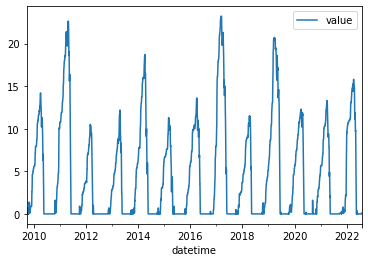

In [11]:
# simple plot to look at our data
ts.plot();

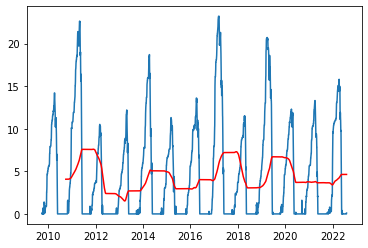

In [38]:
moving_avg = ts.rolling(period).mean()
plt.plot(ts)
plt.plot(moving_avg, color='red')

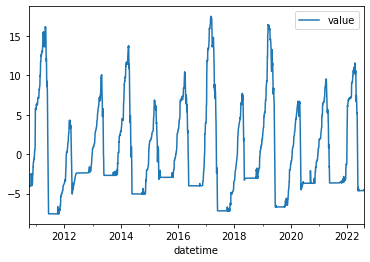

In [43]:
# subtracting rolling mean
ts_diff = ts - moving_avg
ts_diff.dropna(inplace=True)
ts_diff.plot();

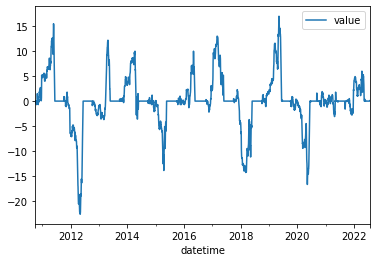

In [60]:
ts_diffs = ts - ts.shift(period)
ts_diffs.dropna(inplace=True)
ts_diffs.plot();

### Testing Stationarity

Here we will use a Dicky-Fuller test to evaluate the stationarity of our time series.

In [58]:
from statsmodels.tsa.stattools import adfuller

# Stationarity function by Jacob Stallone 
# (https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)
# Updated here.
def test_stationarity(timeseries, period=period):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(period).mean()
    rolstd = timeseries.rolling(period).std()
    
    #Plot rolling statistics:
    timeseries.plot( color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

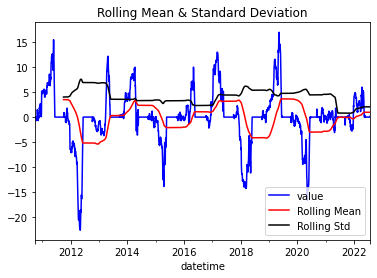

Results of Dickey-Fuller Test:
Test Statistic                   -5.366189
p-value                           0.000004
#Lags Used                       24.000000
Number of Observations Used    4296.000000
Critical Value (1%)              -3.431873
Critical Value (5%)              -2.862213
Critical Value (10%)             -2.567128
dtype: float64


In [61]:
test_stationarity(ts_diffs)

There's clearly seasonality to this data, so lets go ahead and decompose the data into its trend, seasonality and residuals.

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

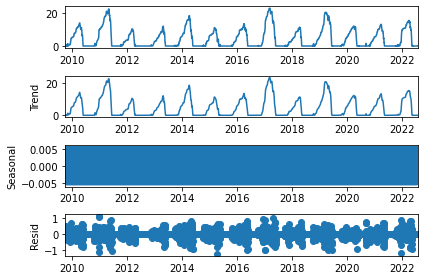

In [17]:
decomp.plot();

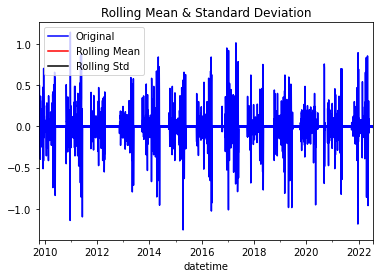

Results of Dickey-Fuller Test:
Test Statistic                  -20.702400
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    4655.000000
Critical Value (1%)              -3.431756
Critical Value (5%)              -2.862161
Critical Value (10%)             -2.567101
dtype: float64


In [18]:
ts_decomposed = residual
ts_decomposed.dropna(inplace=True)
test_stationarity(ts_decomposed)

Now that both our trend and our seasonality has been removed, lets move on to our modeling.

### Modeling Water Equivalent Values

We will construction 3 different models and compare between them:
- **AR**: Auto-Regressive model
- **MA**: Moving-Average model
- **ARIMA**: Auto-Regressive Integrated Moving Average model

First, we have to determine our dependant parameters.
- **p**: Number of Auto-Regressive (AR) terms.
- **q**: Number of Moving-Average (MA) terms.
- **d**: Number of non-seasonal differences.

Deterministic variables:
- **ACF**: measures correlation between two consecutive lags.
- **PACF**: measures cdegree of associate between y(t) and y(t-p).

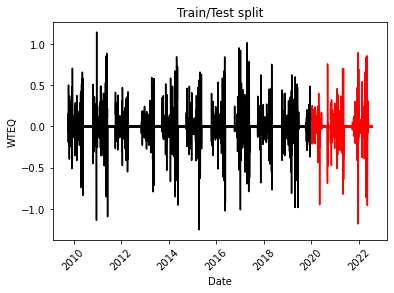

In [87]:
# We'll keep the most recent 20% of our data as a test set.
cutoff = round(ts.shape[0]*0.8)

train = ts_decomposed[:cutoff]
test = ts_decomposed[cutoff:]

plt.plot(train, color='black')
plt.plot(test, color='red')
plt.ylabel('WTEQ')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split")
plt.show();

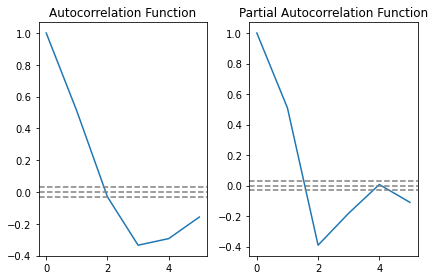

In [76]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

nlags=5

lag_acf = acf(ts_decomposed, nlags=nlags)
lag_pacf = pacf(ts_decomposed, nlags=nlags, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_decomposed)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_decomposed)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_decomposed)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_decomposed)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

### AR Model

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


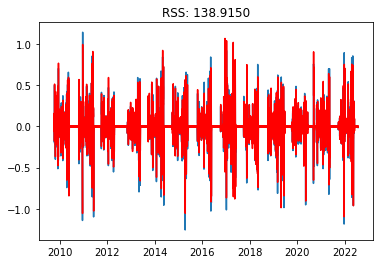

In [69]:
ar_model = ARIMA(ts_decomposed, order=(2, 1, 0))
results_AR = ar_model.fit()
plt.plot(ts_decomposed)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_decomposed)**2));

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


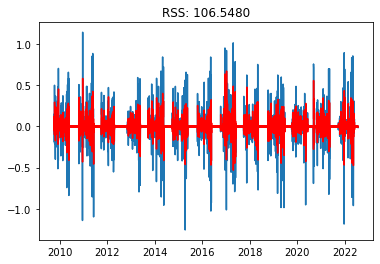

In [71]:
ma_model = ARIMA(ts_decomposed, order=(0, 1, 2))
results_MA = ma_model.fit()
plt.plot(ts_decomposed)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_decomposed)**2));

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


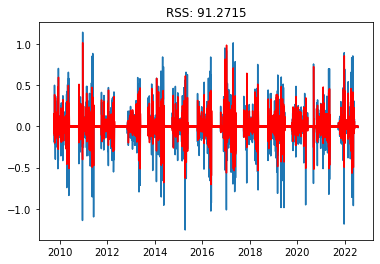

In [72]:
arima_model = ARIMA(ts_decomposed, order=(2, 1, 2))
results_ARIMA = arima_model.fit()
plt.plot(ts_decomposed)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_decomposed)**2));

The **ARIMA** model did best with the lowest RSS, we can now move on to running predictions.

In [88]:
sarimax_model = SARIMAX(ts[:cutoff], seasonal_order=(2,1,2,period))

C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Mouse\miniconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
